# Implementación del circuito de Teletransportación Cuántica en la plataforma Qiskit de IBM.

******************************************************************
Para esta implementación se ha tenido en cuenta la descripción del circuito dada en el siguiente tutorial del libro de Qiskit:

https://qiskit.org/textbook/ch-algorithms/teleportation.html

Además se han tomando instrucciones e ideas del tutorial de la comunidad de desarrolladores de Qiskit disponible en:

https://github.com/Qiskit/qiskit-community-tutorials/blob/master/terra/qis_intro/teleportation_superdensecoding.ipynb

******************************************************************
### Curso de Computación Cuántica
### Prof. Gustavo Patino

Departamento de Ingeniería Electrónica y Telecomunicaciones

Facultad de Ingeniería

Universidad de Antioquia

Medellin, 2020-2025

******************************************************************

In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit.quantum_info import Operator, Statevector, DensityMatrix, random_statevector

from qiskit.visualization import plot_distribution, plot_bloch_multivector
from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_state_city

from qiskit_aer import AerSimulator

In [2]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
# %config InlineBackend.figure_format = 'svg' # Makes the images look nice

# Definición de funciones para implementar las diversas etapas del circuito de teletransportación cuántica

In [3]:
def crear_estado_bell00(qc, a, b):
    qc.h(a)
    qc.cx(a,b)

In [4]:
def circuito_de_alice(qc, q2send, beta0):
    qc.cx(q2send, beta0)
    qc.h(q2send)

In [5]:
def medicion_de_alice(qc, a, b):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)
    qc.barrier()
    qc.barrier()

In [6]:
def circuito_de_bob(qc, beta1, m1, m2):
    # Bob uses the classical bits to conditionally apply gates
    with qc.if_test((m1, 1)):
        qc.z(beta1)
    with qc.if_test((m2, 1)):
        qc.x(beta1)

# Definición del circuito de teletransportación cuántica

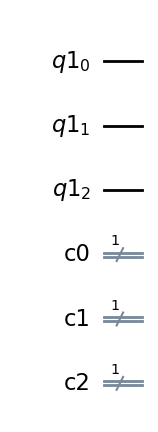

In [7]:
qr = QuantumRegister(3)
crz = ClassicalRegister(1)
crx = ClassicalRegister(1)
crbob = ClassicalRegister(1)
teleport_cir = QuantumCircuit(qr, crz, crx, crbob)

teleport_cir.draw('mpl')

In [8]:
# si la función random_set no está disponible en su instalación del Qiskit, entonces comente las siguientes instrucciones.
# Luego descomente la instrucción de rotación mostrada en la siguiente linea.
qrandom = random_statevector(2)
print(qrandom)

Statevector([ 0.85343265+0.45935015j, -0.18576573-0.16168257j],
            dims=(2,))


In [9]:
print(Statevector(qrandom).probabilities())

[0.93934984 0.06065016]


In [10]:
# type(Statevector(qrandom))

<IPython.core.display.Latex object>

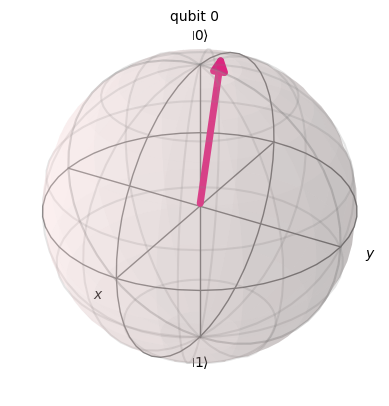

In [11]:
display(array_to_latex(Statevector(qrandom), prefix="\\text{Statevector} = "))
plot_bloch_multivector(Statevector(qrandom))

In [12]:
init_gate = QuantumCircuit(1, name="Random Input") 
# teleport_cir.initialize(qrandom,0)

init_gate.initialize(qrandom,0)

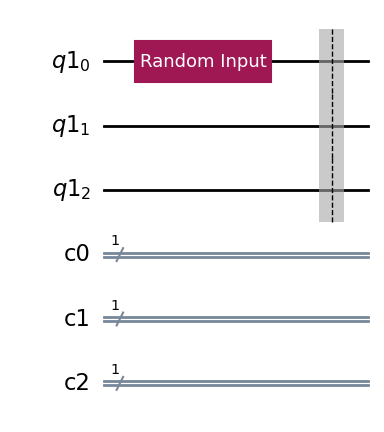

In [13]:
teleport_cir.append(init_gate.to_instruction(), [0])

teleport_cir.barrier()
teleport_cir.draw('mpl')

In [14]:
#teleport_cir.reset(qr[0])
#teleport_cir.draw('mpl')

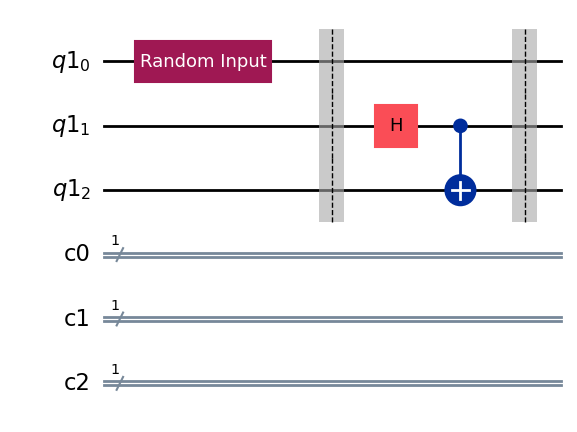

In [15]:
crear_estado_bell00(teleport_cir, qr[1], qr[2])
teleport_cir.barrier()
teleport_cir.draw('mpl')

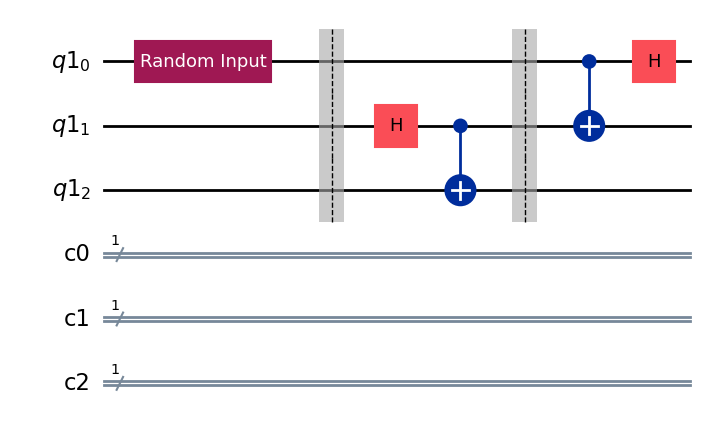

In [16]:
circuito_de_alice(teleport_cir, qr[0], qr[1])
teleport_cir.draw('mpl')

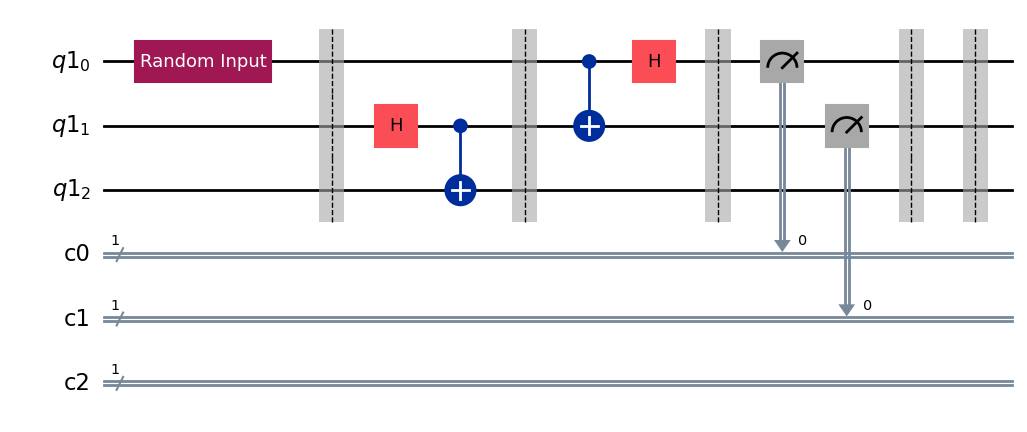

In [17]:
# El resultado de la medida realizada por Alice 
# se envía a Bob por un canal clásico (correo electronico, Whtspp, llamada telefónica).
# Este canal clásico se representa por la doble barrera indicada en el circuito.

medicion_de_alice(teleport_cir, qr[0], qr[1])
teleport_cir.draw('mpl')

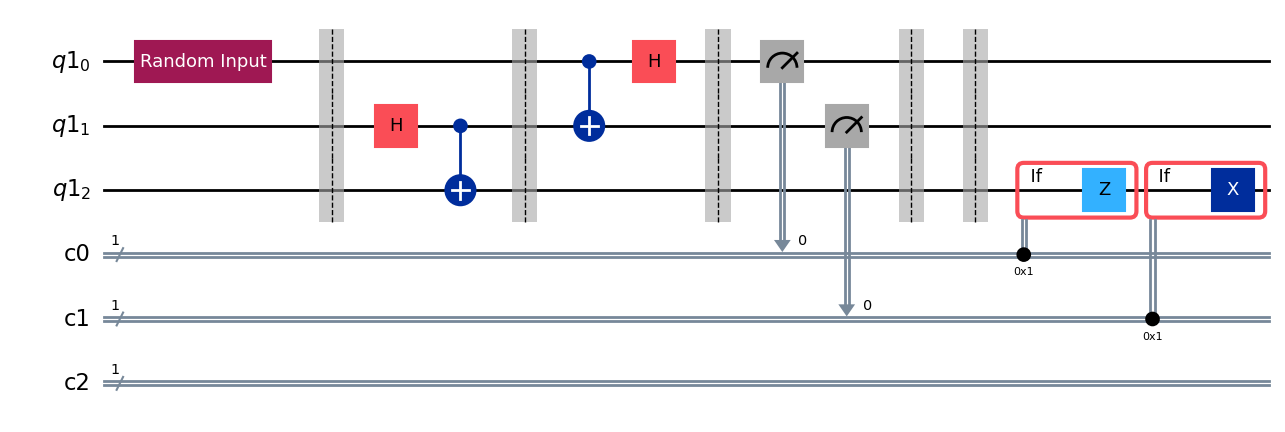

In [18]:
circuito_de_bob(teleport_cir, qr[2], crz, crx)
teleport_cir.draw('mpl')

# Simulación del Vector de Estado a la salida del circuito

In [19]:
teleport_cir_statevector = teleport_cir.copy()
teleport_cir_statevector.save_statevector()

In [20]:
# Transpile for simulator
simulator = AerSimulator(method='statevector')
circ_statevector = transpile(teleport_cir_statevector, simulator)

In [21]:
# Run and get statevector
result = simulator.run(circ_statevector).result()
statevector = result.get_statevector(circ_statevector)

<IPython.core.display.Latex object>

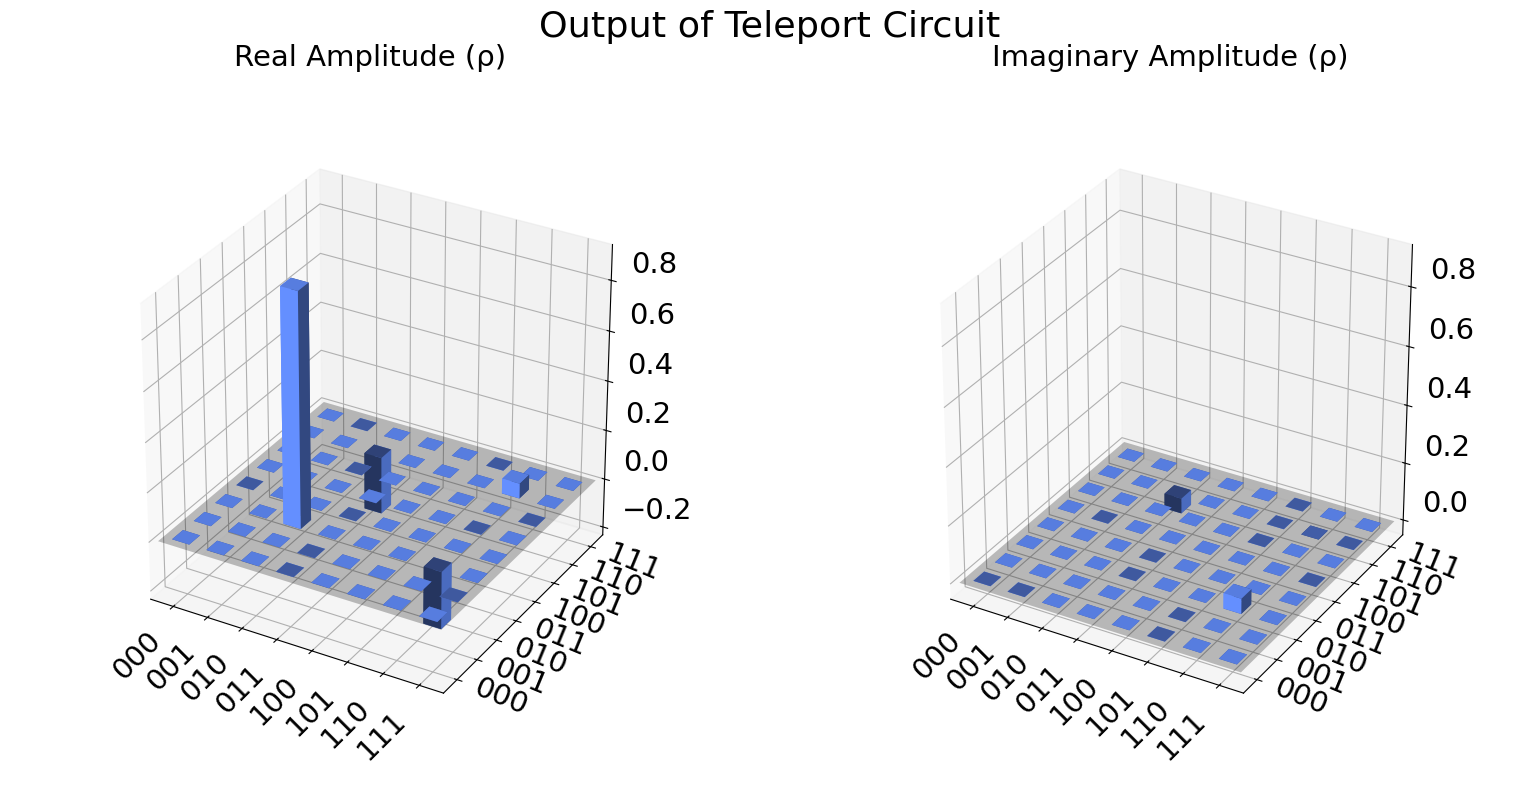

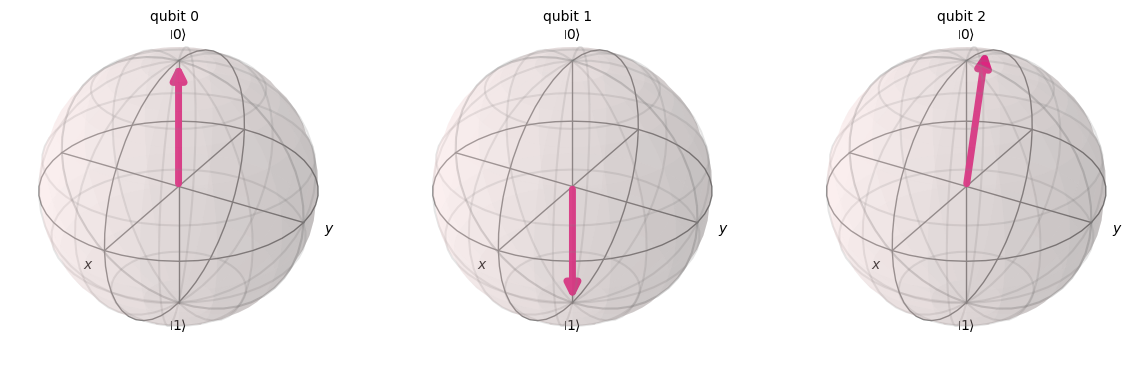

In [22]:
display(array_to_latex(Statevector(statevector), prefix="\\text{Statevector} = "))

display(plot_state_city(statevector, title='Output of Teleport Circuit'))
display(plot_bloch_multivector(statevector))

In [23]:
# La creación del siguiente subconjunto depende de las bits obtenidos por Alice.
bob0 = statevector[int('000',2)]
print(bob0)
bob1 = statevector[int('100',2)]
print(bob1)

-0j
0j


<IPython.core.display.Latex object>

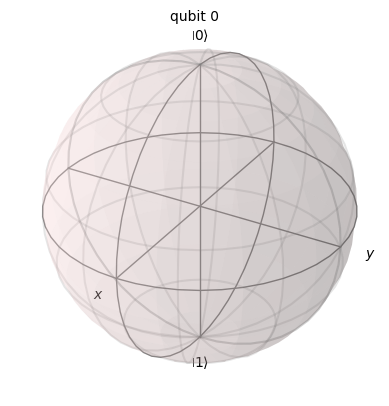

In [24]:
bob = [bob0, bob1]
display(array_to_latex(Statevector(bob), prefix="|\\psi\\rangle ="))
plot_bloch_multivector(Statevector(bob))

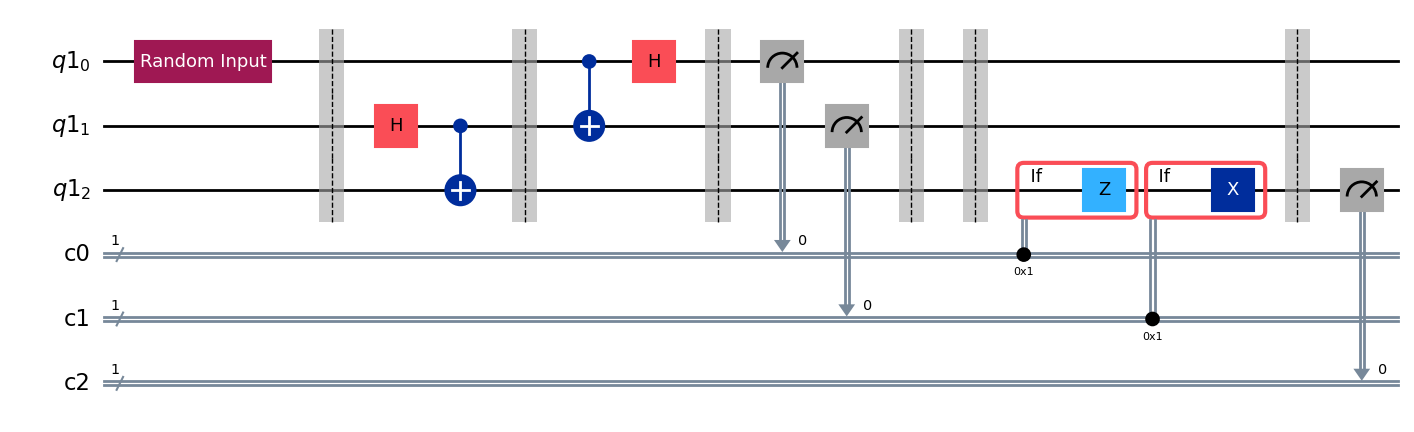

In [25]:
teleport_cir.barrier() # Use barrier to separate steps
teleport_cir.measure(qr[2], crbob[0])
teleport_cir.draw('mpl')

# Simulación del circuito completo

In [26]:
teleport_result = AerSimulator().run(teleport_cir.decompose(reps=1)).result()

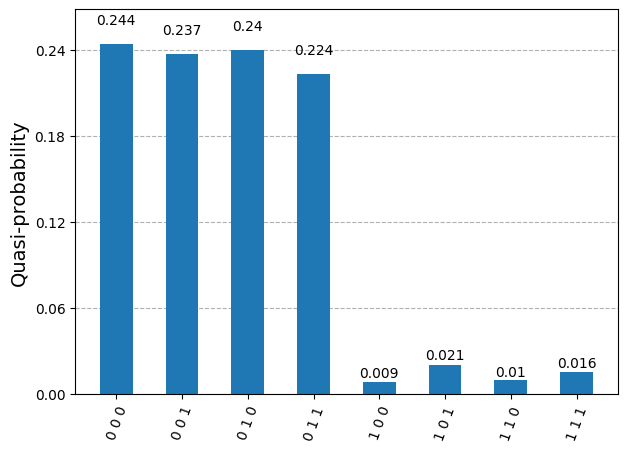

In [27]:
data = teleport_result.get_counts(teleport_cir)
plot_distribution(data)
# En este conjunto de datos de probabilidad está todo el universo del circuito. 
# Los qubits q0 y q1 corresponden a los obtenidos por Alice antes de la medida.
# Y el qubit q2 corresponde al recibido por Bob. 

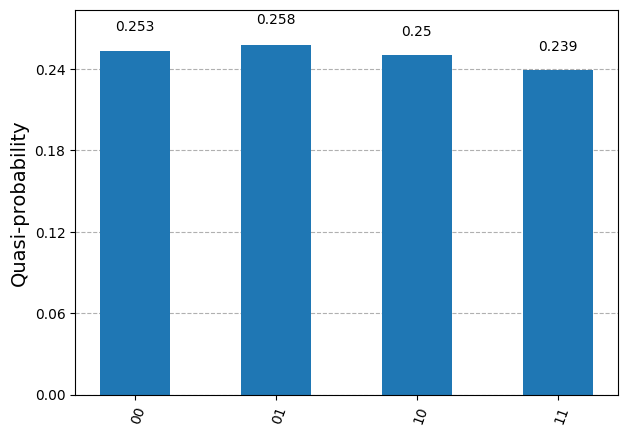

In [28]:
# Con las siguientes instrucciones se pueden extraer de manera más clara los qubits de Alice.
alice = {}
alice['00'] = data['0 0 0'] + data['1 0 0']
alice['10'] = data['0 1 0'] + data['1 1 0']
alice['01'] = data['0 0 1'] + data['1 0 1']
alice['11'] = data['0 1 1'] + data['1 1 1']
plot_distribution(alice)

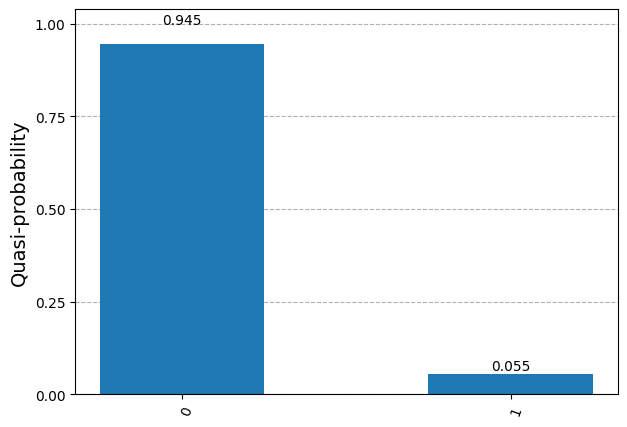

In [29]:
# Y con las siguientes instrucciones se puede extraer de manera más clara el qubit de Bob.
bob = {}
bob['0'] = data['0 0 0'] + data['0 1 0'] +  data['0 0 1'] + data['0 1 1']
bob['1'] = data['1 0 0'] + data['1 1 0'] +  data['1 0 1'] + data['1 1 1']

# print(bob)

plot_distribution(bob)

In [30]:
# Este circuito, como fue descrito en este código, no puede ser implementado en un computador cuántico real de IBM 
# debido a la imposibilidad de agregar compuertas cuánticas luego de que se realice alguna medida.

# Además de ello, en un circuito real de teletransportación cuántica, sería necesario que el circuito de Bob estuviera 
# fisicamente en otro lugar separado del circuito real de Alice, y los bits medidos por Alice se deberían enviar 
# clásicamente al circuito de Bob.

# Aun así, en la próxima clase revisaremos cómo podemos implementar este circuito en un computador cuántico real a fin de
# evaluar su ejecución y tasa de error.

In [31]:
from qiskit import __version__
print(__version__)

1.3.2
